In [1]:
# file specific libraries
import torch
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math, random, torch, collections, time, torch.nn.functional as F, networkx as nx, matplotlib.pyplot as plt, numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from IPython.display import clear_output
from torch_geometric.utils import to_networkx
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from functools import wraps

%matplotlib inline
import sys,os
from models import *
from train_utils import *
from influence_metrics import *


In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import torch
import torch_geometric as tg
import pandas as pd

dataset_name = 'Cora'
dataset = Planetoid(root='../data/Planetoid', name=dataset_name, transform=NormalizeFeatures())
###
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [3]:
#### Simple model
## for GraphSAGE, alpha = 0.5, beta =1 
## for GAT, alpha = , beta = ?

model =GNN(input_dim = data.num_features, hidden_dim=252,
           output_dim = dataset.num_classes, n_layers=2,
           activation ='relu', slope=.1,
           device ='cpu',
          alpha = 0.5, beta = 1, alpha_res = 0, 
           gnn_type = 'symmetric') 
           
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4) #didn't include weight decay
train_acc_list, test_acc_list, loss_list, misclassified, predictions = train(150, model, criterion, optimizer, 
                                                 x= data.x, edge_index= data.edge_index, y=data.y, indicate=True,
                                                m=mask(data.train_mask, data.test_mask),
                                                scatter_size=30, plotting=False)

Training the model
Final test accuracy: 0.79
output:  tensor([3, 4, 4,  ..., 3, 3, 3])


In [33]:
def display_influential_nodes(result): 
    test_size = list(result.keys())
    for test_num in test_size: 
        num_nodes = len(result[test_num]['influential_nodes'])
        print(f"For test number {test_num}, {num_nodes} influential nodes found")
        print(f"  - influential nodes: {list(result[test_num]['influential_nodes'].keys())}")
        print(f"  - final accuracy: {list(result[test_num]['influential_nodes'].values())[-1]}")
    common_nodes = find_common_nodes(result, [])
    len_common_nodes = len(common_nodes)
    print(f"{len_common_nodes} common nodes found: {common_nodes}")
    return common_nodes

In [21]:
#run the same epoch size several time
#result = repeat_pipelines(model, dataset, data, epoch_size=100, display=True, indicate=True)

In [35]:
common_nodes = display_influential_nodes(result)

For test number 1, 8 influential nodes found
  - influential nodes: [0, 1, 2, 6, 10, 68, 95, 110]
  - final accuracy: 0.798
For test number 2, 7 influential nodes found
  - influential nodes: [0, 1, 3, 4, 6, 12, 23]
  - final accuracy: 0.799
For test number 3, 12 influential nodes found
  - influential nodes: [0, 1, 2, 3, 4, 10, 29, 31, 58, 64, 68, 135]
  - final accuracy: 0.798

common nodes: {0, 1}
2 common nodes found: {0, 1}


In [66]:
dc_g = nx.degree_centrality(F.to_networkx(dataset[0]))
bc_g = nx.betweenness_centrality(F.to_networkx(dataset[0]))
dc_df=pd.DataFrame(data=dc_g, index=['Degree Centrality']).transpose()
bc_df=pd.DataFrame(data = bc_g, index=['Betweenness Centrality']).transpose()
centrality = dc_df.join(bc_df)

In [126]:
bc_df.idxmax(axis='index')
new = pd.DataFrame(data=dc_g, index=['Degree Centrality']).transpose()
new.idxmax(axis='index')

Betweenness Centrality    1358
dtype: int64

Degree Centrality    1358
dtype: int64

<BarContainer object of 2708 artists>

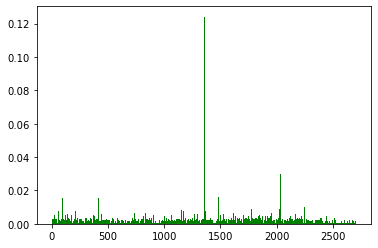

In [92]:
plt.bar(height=dc_g.values(), x=dc_g.keys(), width=1, color='g')

<BarContainer object of 2708 artists>

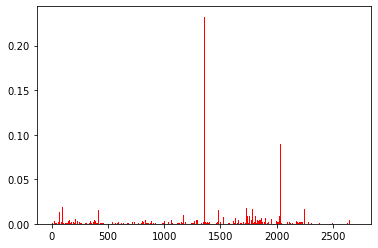

In [93]:
plt.bar(height=bc_g.values(), x=bc_g.keys(), width=1, color='r')

In [131]:
## compute until 140 node? (the number of train_nodes)

In [36]:
dc = compute_centrality(dataset, common_nodes, 'Degree Centrality')
bc = compute_centrality(dataset, common_nodes, 'Betweenness Centrality')
print(dc, bc)

search result: 
{0: 0.0022164758034724785, 1: 0.0022164758034724785}
search result: 
{0: 9.76615354875872e-07, 1: 0.001080476705520546}
{0: 0.0022164758034724785, 1: 0.0022164758034724785} {0: 9.76615354875872e-07, 1: 0.001080476705520546}


In [134]:
print(f"total nodes of {len(bc_g)}")
total = len(bc_g)
count_bc0, count_bc1 = 0, 0
for i in range(2, 140):
    if centrality['Betweenness Centrality'][i] < bc[0]: count_bc0+=1
    if centrality['Betweenness Centrality'][i]  < bc[1]: count_bc1+=1

print(f"{count_bc0/total*100: 0.1f} percentage of nodes have higher betweenness centrality than 0")
print(f" {count_bc1/total*100:0.1f} percentage of nodes have higher betweenness centrality than 0")

total nodes of 2708
 1.5 percentage of nodes have higher betweenness centrality than 0
 3.7 percentage of nodes have higher betweenness centrality than 0


In [133]:
print(f"total nodes of {len(dc_g)}")
count_dc0, count_dc1 = 0, 0
for i in range(2, 140):
    if centrality['Degree Centrality'][i] <  dc[0]: count_dc0+=1
    if centrality['Degree Centrality'][i]  < dc[1]: count_dc1+=1
print(f" {count_dc0/total*100:0.1f} percentage of nodes have higher betweenness centrality than 0")
print(f" {count_dc1/total*100:0.1f} percentage of nodes have higher betweenness centrality than 0")

total nodes of 2708
 1.7 percentage of nodes have higher betweenness centrality than 0
 1.7 percentage of nodes have higher betweenness centrality than 0


In [137]:
dc_count = [0 for _ in range(len(dc))]
for i in range(2, 140):
    for j in dc: 
        if centrality['Degree Centrality'][i] < j: dc_count[j] += 1 
for i in range(len(dc)): 
    print(f" {dc_count[i]/total*100:0.1f} percentage of nodes have higher degree centrality than {i}")

bc_count = [0 for _ in range(len(dc))]
for i in range(2, 140):
    for j in bc: 
        if centrality['Betweenness Centrality'][i] < j: bc_count[j] += 1 
for i in range(len(dc)): 
    print(f" {dc_count[i]/total*100:0.1f} percentage of nodes have higher betweenness centrality than {i}")


 0.0 percentage of nodes have higher degree centrality than 0
 5.1 percentage of nodes have higher degree centrality than 1
 0.0 percentage of nodes have higher betweenness centrality than 0
 5.1 percentage of nodes have higher betweenness centrality than 1


In [22]:
similarities = node_similarity(dataset, common_nodes)

search result: 
{0: 0.0022164758034724785, 1: 0.0022164758034724785}


TypeError: unhashable type: 'Data'

In [ ]:
plot_distribution(influential_class, heavily_affected_nodes):

In [ ]:
for i in range(len(dataframe.columns)): 
    max_sim = 0
    idx1, idx2 = 1, 2
    for j in range(i, len(dataframe.columns)):
        similarity = dataframe[i][j] 
        if similarity != 1 and similarity != 0: 
            if max_sim < similarity: 
                max_sim = similarity 
                print(max_sim)
                idx1, idx2 = i, j
            print(f"{i}, {j} pair with similarity level {similarity:.3f}")
    
print(f"most similar pair: {idx1}, {idx2}" )

In [ ]:
dataframe

for i in 

# to do 
**misclassification** 
1. for each misclassified nodes, can I find a node responsible to the misclassification? 
2. what is the most dominant misclassified class? 

**influential nodes** 
1. for each influential node, can I figure out which class the node is in, and for which nodes the node results in misclassification? 
2. what is the relationship of the influential node to the misclassified node? 
3. what is the relationship amongst the influential nodes? 
4. if I take all of the influential nodes out, does that lead to increase in inaccuracy? or decrease? is there a consistent result? 


numbers are just numbers without context. try to write the print function wisely. 
compute the simrank for the entire graph - the group's simrank is significantly different from the group 
random paris of the graph and average out? 

# links
node similarity: https://towardsdatascience.com/simrank-similarity-analysis-1d8d5a18766a
 0 if have the same parents, return a similarity value


In [ ]:
outputs, output_differences, kl_scores, accuracies = check_pipeline(model, dataset, data, data.train_mask,
                   data.test_mask,
                   n_epochs=200,   
                   original_output=None,
                   indicate=True, \
                   return_prediction=True,
                   compute_y_differences=True,
                   dimension=32,
                   task='classification',
                   loss_function=torch.nn.CrossEntropyLoss(),
                   lr=0.001)

## spare codes

In [ ]:
# u = model(data.x, data.edge_index)

In [ ]:
#  F.mse_loss(u, u)

In [ ]:
# loo_pipeline(model, dataset, data,data.train_mask,
#                  data.test_mask, 1,
#                  10,
#                  original_output=None,
#                  compute_y_differences=True,
#                  task='classfication',
#                  loss_function=torch.nn.CrossEntropyLoss(),
#                  lr=0.001)